In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Silence warnings
import warnings
warnings.filterwarnings("ignore")

## Configuration

In [2]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

## Get the data

In [4]:
# Importing csv's
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [5]:
# Dropping id's
train_df.drop(['id'], axis=1, inplace=True)

In [ ]:
print(pd.value_counts(train_df['Sex'], ascending=True))

F    23010
I    23957
M    27084
Name: Sex, dtype: int64


## EDA

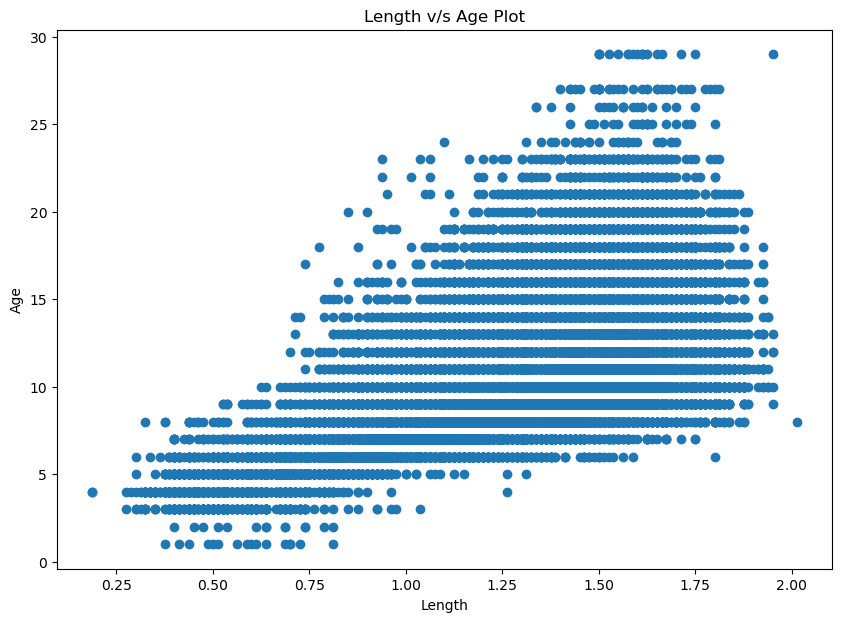

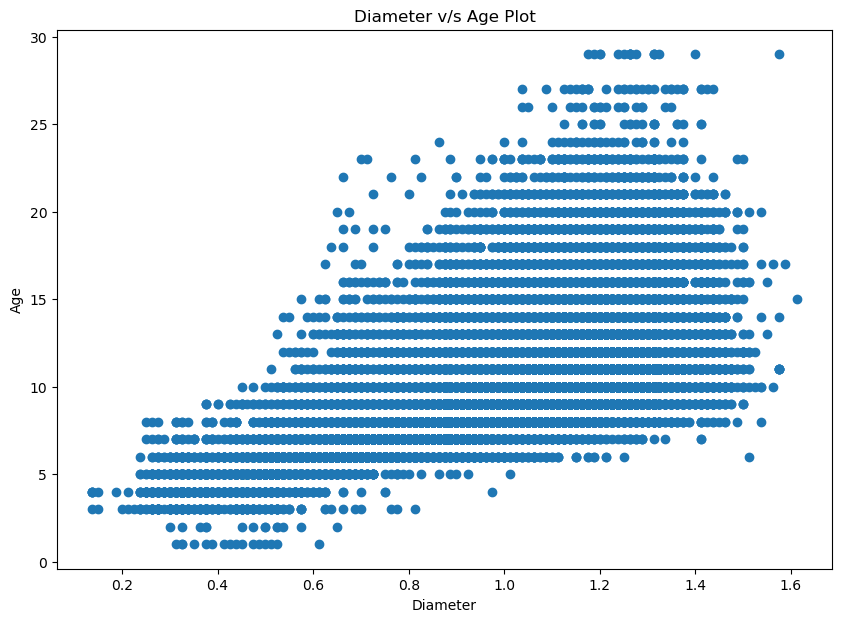

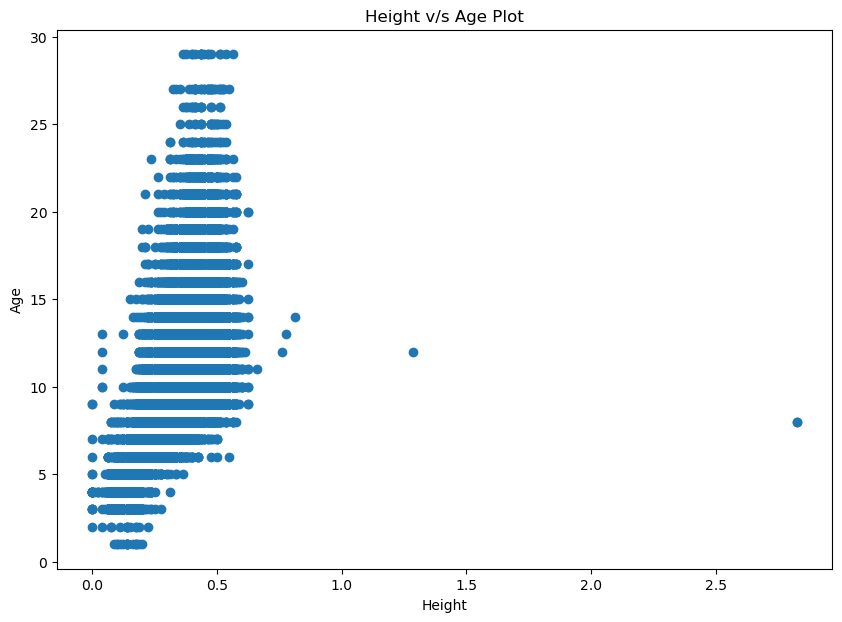

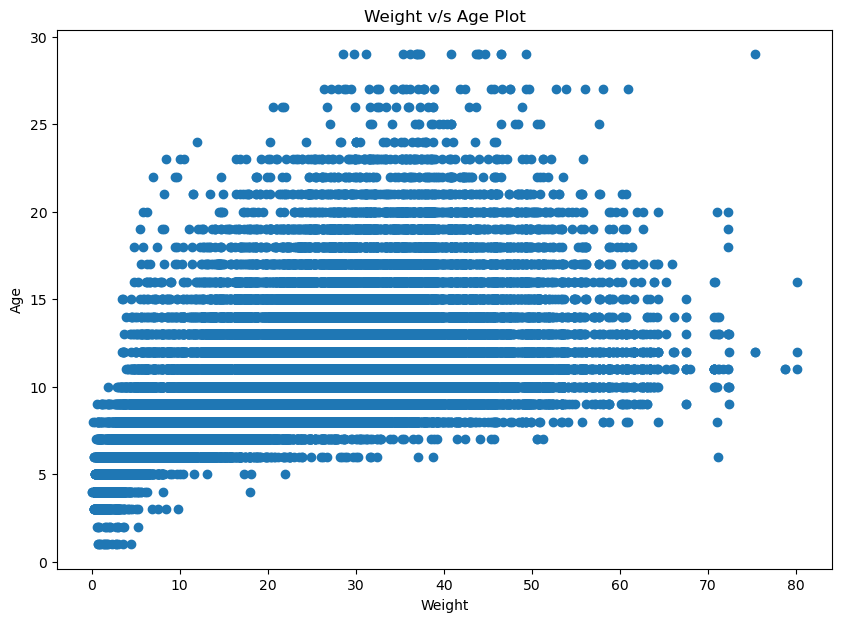

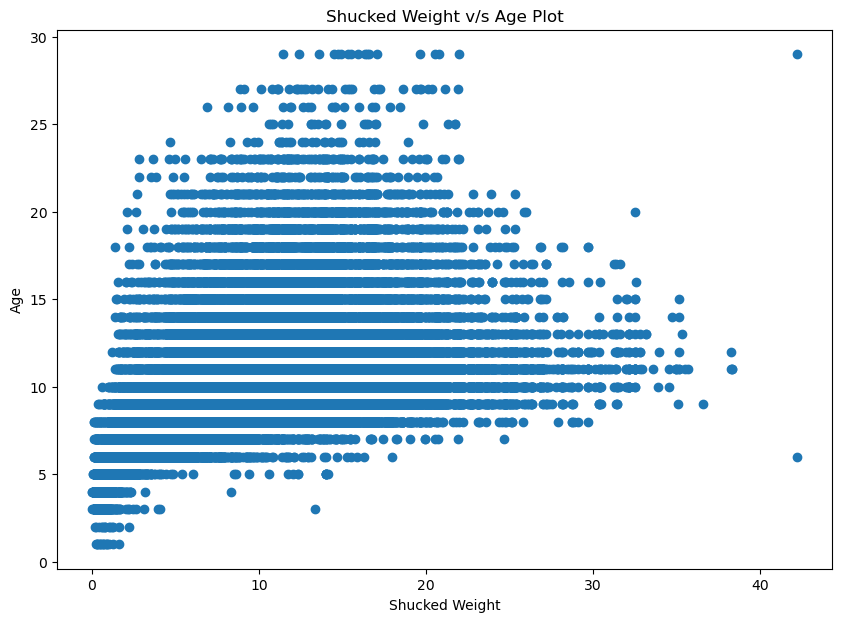

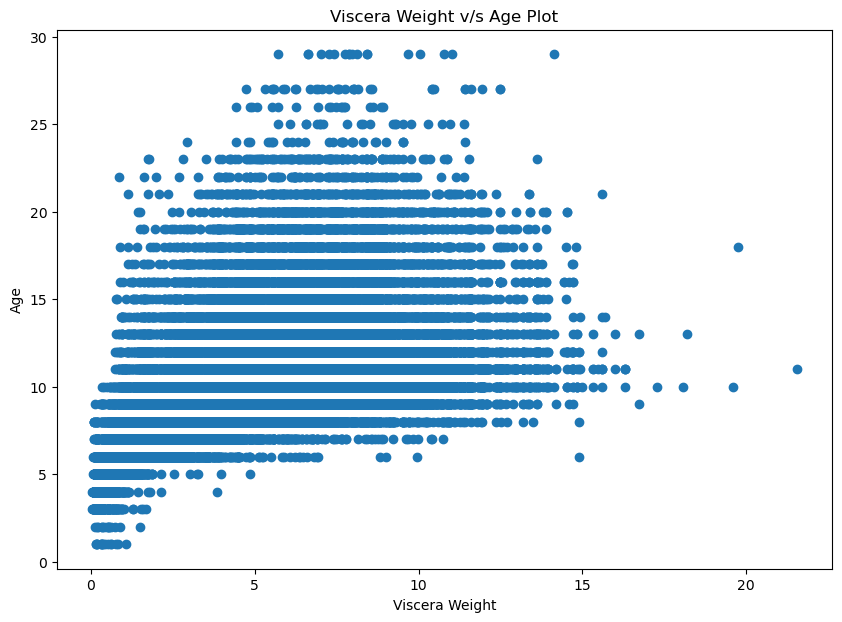

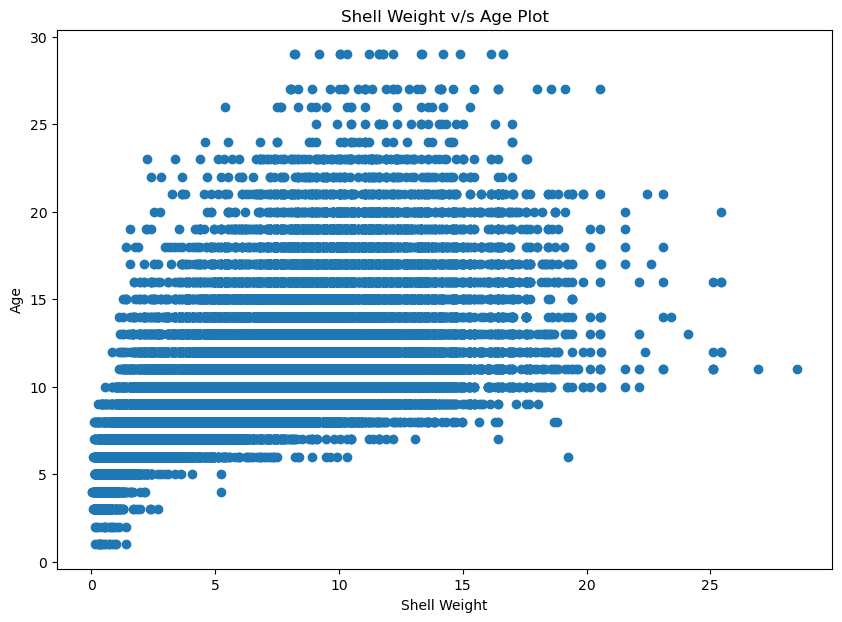

In [ ]:
plot_features = (train_df.columns).tolist()
plot_features.remove('Age')
plot_features.remove('Sex')
for feature in plot_features:
    plt.figure(figsize=(10,7))
    plt.scatter(x=train_df[feature], y=train_df['Age'])
    plt.xlabel(str(feature))
    plt.ylabel('Age')
    plt.title(f"{str(feature)} v/s Age Plot")
    plt.show()

In [6]:
# Converting sex to dummy variables
train_df = pd.get_dummies(train_df, columns=['Sex'])

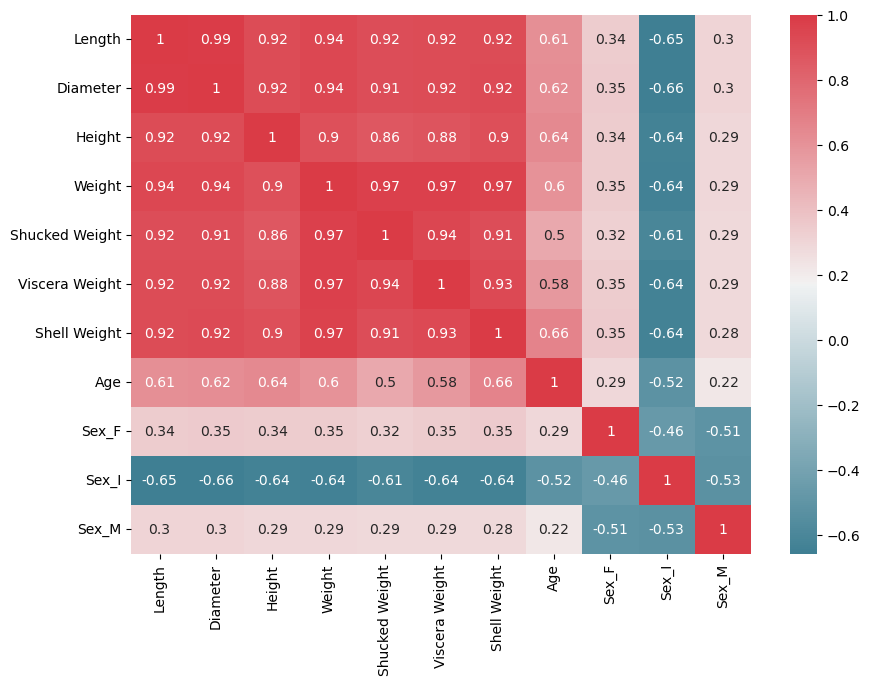

In [ ]:
# Correlation Matrix
corr = train_df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)
plt.show()

In [ ]:
corr['Age']

Length            0.612843
Diameter          0.621256
Height            0.638067
Weight            0.601195
Shucked Weight    0.503320
Viscera Weight    0.576808
Shell Weight      0.663473
Age               1.000000
Sex_F             0.290494
Sex_I            -0.515909
Sex_M             0.221978
Name: Age, dtype: float64

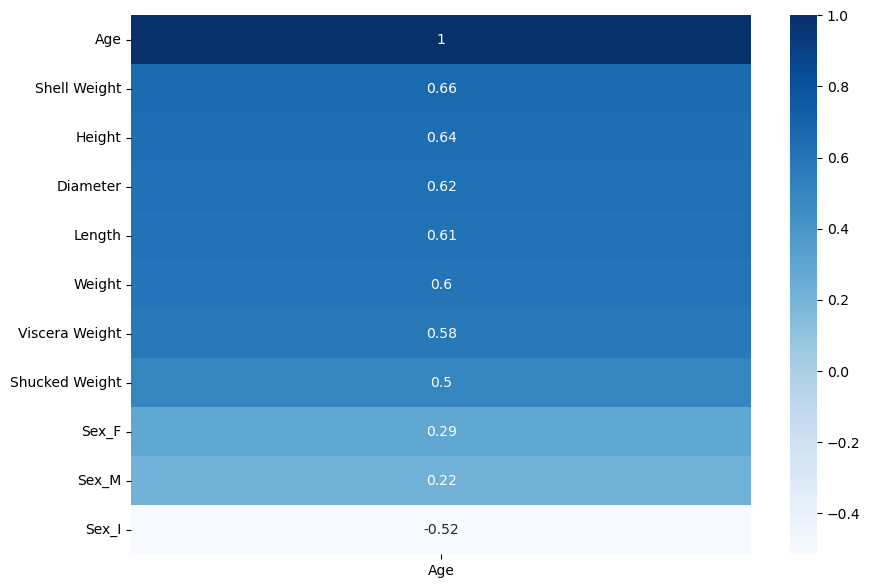

In [ ]:
# Only for target variable
plt.figure(figsize=(10,7))
age_corr = corr.sort_values(by=['Age'], ascending=False)
sns.heatmap(age_corr['Age'].to_frame(), annot=True, cmap='Blues')
plt.show()

In [ ]:
train_df.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0,1,0


## Feature Engineering and Data Preparation

In [7]:
cont_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

processor = ColumnTransformer([
    ('cont_pipeline', pipeline, cont_features)
], remainder="passthrough")

train_df_scaled = pd.DataFrame(processor.fit_transform(train_df), columns=train_df.columns)


In [8]:
train_df_scaled.columns

Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age', 'Sex_F', 'Sex_I', 'Sex_M'],
      dtype='object')

In [ ]:
# Train Test Split
X = train_df_scaled.drop(['Age'], axis=1)
Y = train_df_scaled['Age']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Preaparation

In [ ]:
models = []
model_r2 = []
model_mae = []
model_mse = []

In [ ]:
# Models to be used
lin_reg = LinearRegression()
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=4,
	min_samples=2,
	loss='absolute_error',
	residual_threshold=10
)
tree = DecisionTreeRegressor(max_depth=5)
forest = RandomForestRegressor(
    n_estimators=20,
    max_depth=10,
    criterion="squared_error"
)

In [ ]:
# Evaluation Metrics
def print_scores(Y_true, Y_pred, model):
    models.append(model)
    r2 = r2_score(Y_true, Y_pred)
    sq = mean_squared_error(Y_true, Y_pred)
    absl = mean_absolute_error(Y_true, Y_pred)
    model_r2.append(r2)
    model_mae.append(sq)
    model_mse.append(absl)
    print(f"R2 Score : {r2}")
    print(f"Mean Squared Error : {sq}")
    print(f"Mean Absolute Error : {absl}")

In [ ]:
# Linear Regression
lin_reg.fit(X_train, Y_train)

LinearRegression()

In [ ]:
Y_pred_lin_reg = lin_reg.predict(X_val)
print_scores(Y_val, Y_pred_lin_reg, "Linear Regression")

R2 Score : 0.5569811816792245
Mean Squared Error : 4.515055910459147
Mean Absolute Error : 1.4886169157803935


In [ ]:
# RANSAC Regressor
ransac.fit(X_train, Y_train)

RANSACRegressor(estimator=LinearRegression(), max_trials=4, min_samples=2,
                residual_threshold=10)

In [ ]:
Y_pred_ransac = ransac.predict(X_val)
print_scores(Y_val, Y_pred_ransac, "RANSAC Regression")

R2 Score : 0.5517129848184824
Mean Squared Error : 4.56874709103634
Mean Absolute Error : 1.4734776237657385


In [ ]:
# Decision Tree
tree.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=5)

In [ ]:
Y_pred_tree = tree.predict(X_val)
print_scores(Y_val, Y_pred_tree, "Tree Regression")

R2 Score : 0.5399495635991796
Mean Squared Error : 4.68863478498296
Mean Absolute Error : 1.5049322693577183


In [ ]:
# Random Forest
forest.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, n_estimators=20)

In [ ]:
Y_pred_forest = forest.predict(X_val)
print_scores(Y_val, Y_pred_forest, "Random Forest Regression")

R2 Score : 0.5837526187850666
Mean Squared Error : 4.242213019056966
Mean Absolute Error : 1.4210019483224792


In [ ]:
matrics = pd.DataFrame(zip(models, model_r2, model_mae, model_mse),columns=['Model', 'R2', 'MAE', 'MSE'])

In [ ]:
matrics

,Model,R2,MAE,MSE
0,Linear Regression,0.556981,4.515056,1.488617
1,RANSAC Regression,0.551713,4.568747,1.473478
2,Tree Regression,0.539950,4.688635,1.504932
3,Random Forest Regression,0.583753,4.242213,1.421002
